# Lecture 8

## Bootstrapping the Standard Errors and Test Statistics of Linear Regression

This example will demonstrate how to run a simple bootstrap in a context we are already familiar with: linear regression.

Since we can calculate the standard error directly (R does it for you), this example will allow us to verify that the bootstrap yields the same result. 

### Simulating a dataset with true values $\beta_0=0$, $\beta_1=1$


In [1]:
set.seed(1)
n <- 200 #number of observations per sample

b0 <- 0
b1 <- 1

x <- rnorm(n) #generate predictors

e <- 5*rnorm(n) #draw 1 sample of errors

y <- b0 + b1*x + e # create 1 dataset

lm.fit=lm(y~x)
bh <- coef(lm.fit)

summary(lm.fit)


Call:
lm(formula = y ~ x)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.6638  -2.7136  -0.1262   3.3417  12.9308 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   0.2073     0.3584   0.578   0.5637  
x             0.8846     0.3865   2.289   0.0231 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.065 on 198 degrees of freedom
Multiple R-squared:  0.02578,	Adjusted R-squared:  0.02086 
F-statistic:  5.24 on 1 and 198 DF,  p-value: 0.02313


**So the R function lm.fit() reports a standard error of 0.3865 for $\hat\beta_1$**

### Bootstrap Standard Errors

In [2]:
B <- 10000 #number of bootstrap re-samples

bhs=matrix(,2,B) #initialize matrix to store estimates of beta

for (b in 1:B){
    index <-sample(n,n, replace=TRUE) #for each loop, reshuffle the indexes of the data WITH REPLACEMENT
    
    lm.bs.fit=lm(y[index]~x[index]) # estimate the linear model on the reshuffled sample.
    bhs[1:2,b] <- coef(lm.bs.fit)   #store the estimates    
}

In [6]:
summary(lm.bs.fit)


Call:
lm(formula = y[index] ~ x[index])

Residuals:
     Min       1Q   Median       3Q      Max 
-14.6494  -3.2825   0.6891   3.2707  13.3464 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.2426     0.3705   0.655 0.513405    
x[index]      1.3674     0.3817   3.582 0.000429 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.209 on 198 degrees of freedom
Multiple R-squared:  0.06086,	Adjusted R-squared:  0.05611 
F-statistic: 12.83 on 1 and 198 DF,  p-value: 0.0004292


In [15]:
sd(bhs[2,]) # The standard deviation of the bootstrap estimates

[1] 0.3925426

**The bootstrap standrd error is very close to the one reported by lm.fit()!**

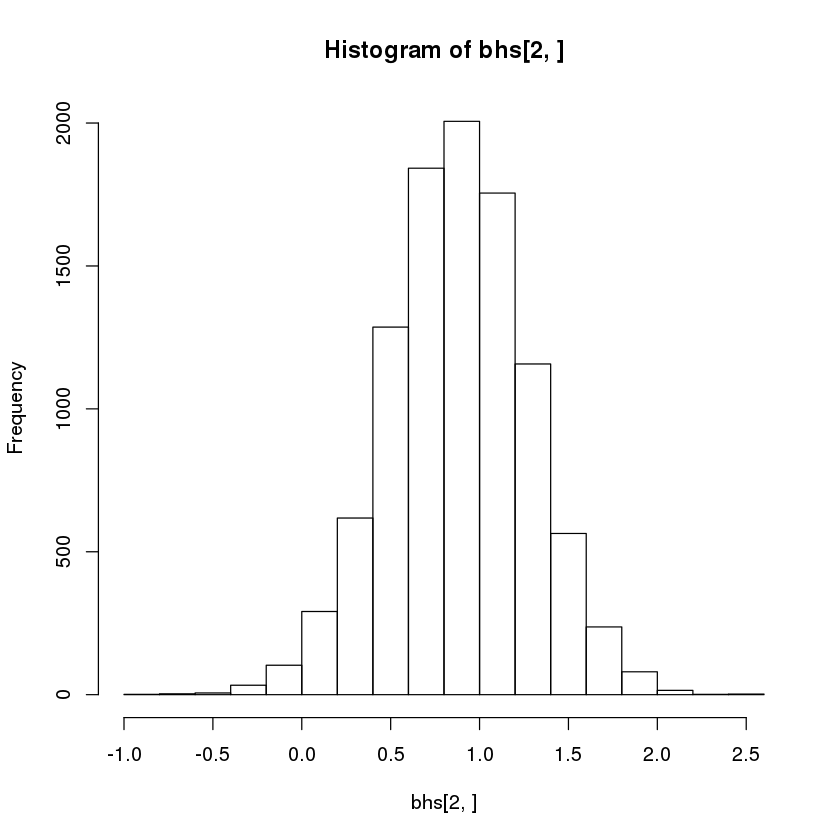

In [16]:
hist(bhs[2,])

### Bootstrap Tests - Resampling Residuals

We can also run statistical tests with the bootstrap. For example, testing whether $\beta_1=0$.

Recall that when we want to test a hypothesis, we need to know the distribution  of the test statistic under the null hypothesis 
$$t = \frac{\hat\beta - \beta_\text{null}}{SE(\hat\beta)}$$

To do this with the bootstrap, we have to generate a bootstrap sample UNDER THE NULL HYPOTHESES we wish to test.

We can't simply reshuffle the data now, because it might have been generated with some $\beta_1 \neq0$. 

So we have to generate this new data somehow... This would require us to know the errors, which are, in principle, unobservable...

Instead, we can use the residuals from the original regression. 

In [17]:
residuals <-lm.fit$residuals

B <- 9999 #number of samples
ts=matrix(,2,B) #initialize matrix to store estimates of beta

for (b in 1:B){
    e.bs <-sample(residuals, replace=TRUE) #for each loop, generate a new sample of residuals WITH REPLACEMENT
    
    y.bs <- bh[1] + 0*x + e.bs # generate a bootstrap sample UNDER THE NULL HYPOTHESIS of beta_1 =0
    
    lm.bs.fit=lm(y.bs~x) # estimate the linear model on the bootstrap sample.
    ts[1:2,b] <- summary(lm.bs.fit)$coefficient[,3]  #store the t-statistics from this sample 
}

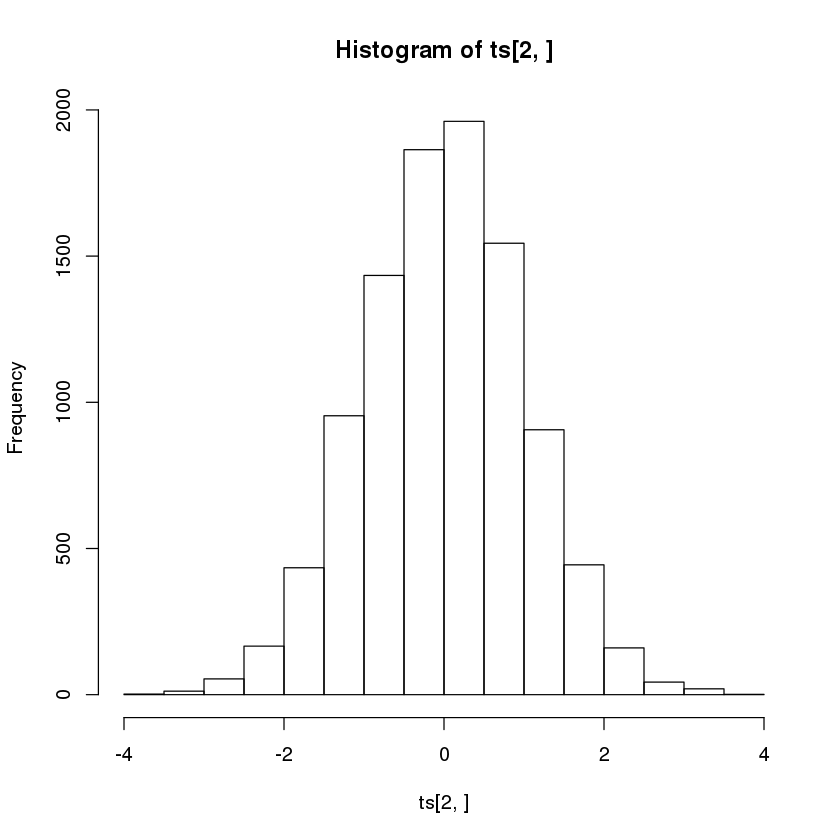

In [18]:
hist(ts[2,])

This should look like the t-distribution...

To check, we can calculate the $97.5\%$ and $2.5\%$ percentile...

In [19]:
quantile(ts[2,],0.975)
quantile(ts[2,],0.025)

97.5% 
1.963464

2.5% 
-1.957458

In [20]:
qt(0.975,n-1) #the 97.5% from the t-distribution
qt(0.025,n-1)

[1] 1.971957

[1] -1.971957

Yup, those are pretty good matches!

Now, we can calulate a p-value from our bootstrap data. That is, how many of the bootstrap t-stats lie above our original t-stat from the lm.fit() regression?

In [21]:
tstat <- summary(lm.fit)$coefficient[2,3] #the original t-stat

mean(ts[2,]> tstat) #what proportion of bootstrap test statistics lie above the original test statistic?

[1] 0.01120112

This is pretty close to the original p-value!

In [22]:
summary(lm.fit)$coefficient[2,4] #original p-value

[1] 0.02313333

In [7]:
ts[2,]

ERROR: Error in ts[2, ]: object of type 'closure' is not subsettable


As the number of bootstrap sample goes to $\infty$, it will get even closer